# Predicting Heart Disease in the Hungarian Dataset: The Role of Age, Cholesterol, and Maximum Heart Rate

## Introduction

Heart disease is the leading global cause of death, emphasizing the need for effective early detection. This project employs predictive modelling to assess how age, cholesterol, and maximum heart rate might predict heart disease using the Hungarian subset from the UCI Heart Disease collection. The primary question I aim to answer is: "Can age, cholesterol levels, and maximum heart rate predict the presence of heart disease in the Hungarian dataset?" Addressing this could significantly improve strategies for heart disease prevention and management.

In [1]:
# Loading necessary libraries for data manipulation, visualization, and modeling
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6) # Limiting the maximum number of rows displayed to enhance readability

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Reading The Data

In [2]:
# Load the Hungarian heart disease dataset, treating '?' as NA for missing values
hungarian_data <- read_csv("data/heart_disease/processed.hungarian.data", na = "?")

New names:
• `2` -> `2...3`
• `0` -> `0...6`
• `2` -> `2...7`
• `0` -> `0...9`
• `0` -> `0...10`
• `?` -> `?...11`
• `?` -> `?...12`
• `?` -> `?...13`
• `0` -> `0...14`
Rows: 293 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): 28, 1, 2...3, 130, 132, 0...6, 2...7, 185, 0...9, 0...10, ?...11, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Data Cleaning and Wrangling

In [3]:
# Set column names, convert data types, and handle missing values for the Hungarian heart disease dataset

colnames(hungarian_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", 
                              "ca", "thal", "num")

hungarian_data <- hungarian_data |>
                  mutate(
                    age = as.numeric(age),
                    chol = as.numeric(chol),
                    thalach = as.numeric(thalach),
                    num = as.factor(num),  # Convert target variable for classification
                    thalach = replace(thalach, is.na(thalach), mean(thalach, na.rm = TRUE))  # Impute missing values if any
                  )

hungarian_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
30,0,1,170,237,0,1,170,0,0,NA,NA,6,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,NA,NA,1
58,0,2,180,393,0,0,110,1,1,2,NA,7,1
65,1,4,130,275,0,1,115,1,1,2,NA,NA,1


## Splitting Data into Training and Testing Sets

In [4]:
set.seed(123)  # Setting a seed to make the split reproducible
split <- initial_split(hungarian_data, prop = 0.75, strata = num) # Split 75% for training, 25% for testing, stratified by heart disease presence
training_data <- training(split)
testing_data <- testing(split)

## Summarizing the Training Data

In [5]:
# Generate a summary table for the training data with key statistics

summary_table <- training_data |>
                  summarize(
                    Total_Observations = n(),
                    Mean_Age = mean(age, na.rm = TRUE),
                    Mean_Cholesterol = mean(chol, na.rm = TRUE),
                    Mean_Max_Heart_Rate = mean(thalach, na.rm = TRUE),
                    Heart_Disease_Presence = sum(num == "1", na.rm = TRUE),
                    Missing_Data = sum(is.na(age) + is.na(chol) + is.na(thalach))
                  )
summary_table

Total_Observations,Mean_Age,Mean_Cholesterol,Mean_Max_Heart_Rate,Heart_Disease_Presence,Missing_Data
<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
219,48.24658,251.25,138.9131,79,15


## Visualizing the Training Data

Warning message:
“Removed 15 rows containing non-finite outside the scale range (`stat_bin()`).”


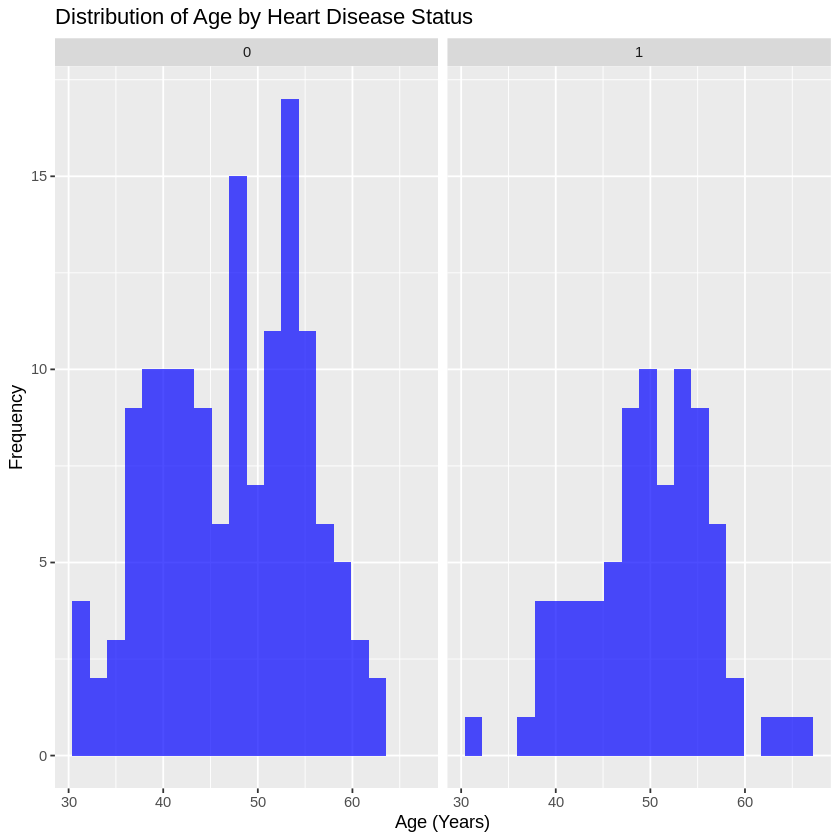

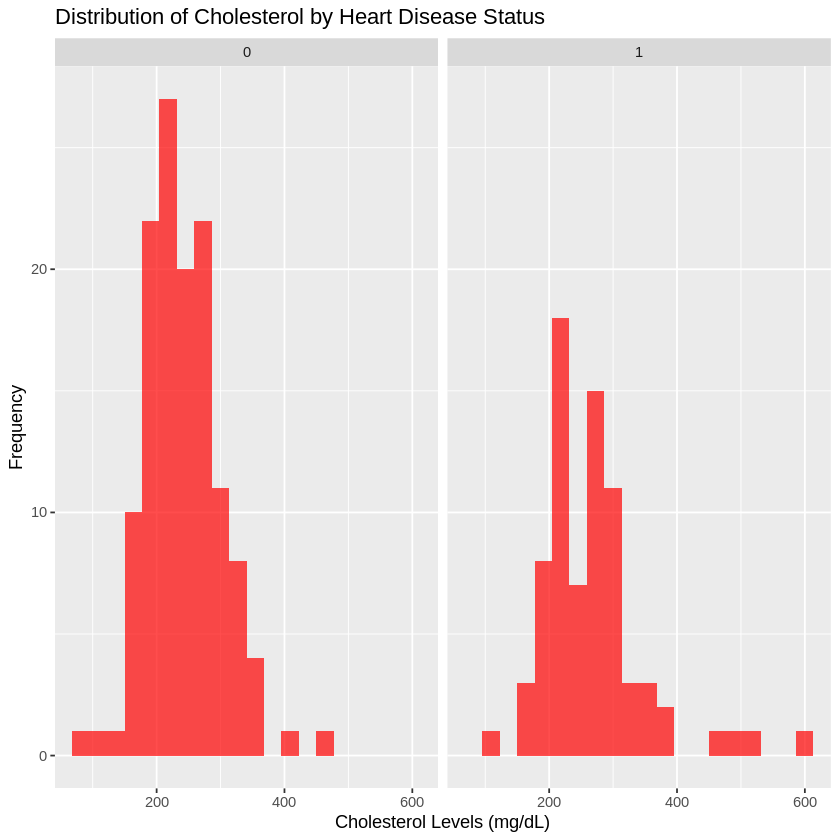

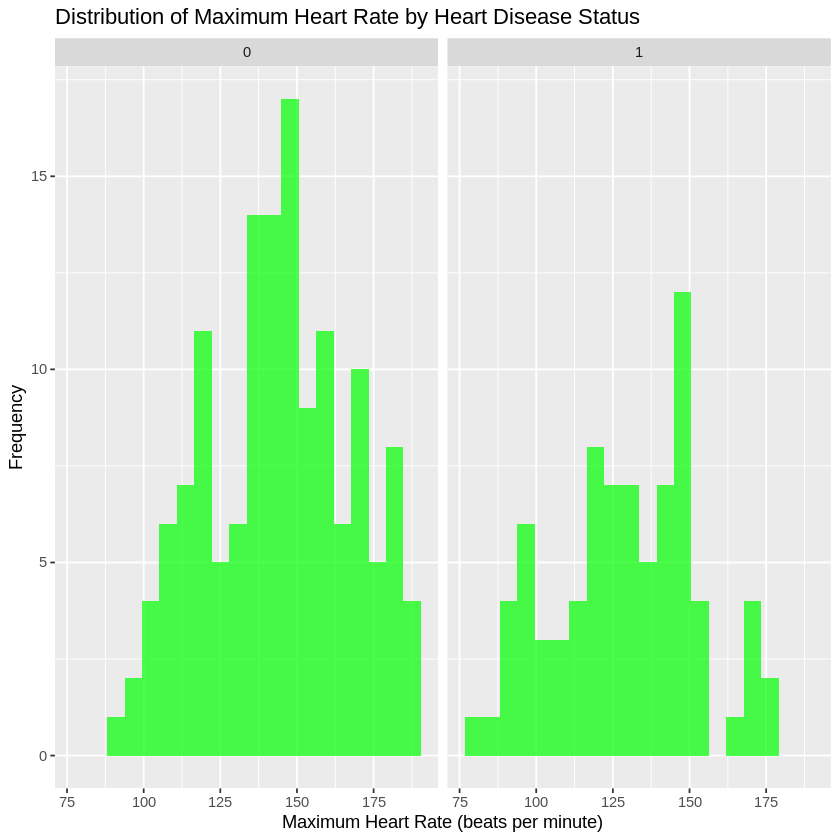

In [6]:
# Histogram for Age Distribution by Heart Disease Status
ggplot(training_data, aes(x = age)) +
  geom_histogram(bins = 20, fill = "blue", alpha = 0.7) +
  facet_wrap(~num) +
  labs(title = "Distribution of Age by Heart Disease Status",
       x = "Age (Years)",
       y = "Frequency")

# Histogram for Cholesterol Distribution by Heart Disease Status
ggplot(training_data, aes(x = chol)) +
  geom_histogram(bins = 20, fill = "red", alpha = 0.7) +
  facet_wrap(~num) +
  labs(title = "Distribution of Cholesterol by Heart Disease Status",
       x = "Cholesterol Levels (mg/dL)",
       y = "Frequency")

# Histogram for Maximum Heart Rate Distribution by Heart Disease Status
ggplot(training_data, aes(x = thalach)) +
  geom_histogram(bins = 20, fill = "green", alpha = 0.7) +
  facet_wrap(~num) +
  labs(title = "Distribution of Maximum Heart Rate by Heart Disease Status",
       x = "Maximum Heart Rate (beats per minute)",
       y = "Frequency")

## Data Distributions by Heart Disease Status

- Metrics: `0` indicates no heart disease, `1` indicates its presence.

### Age
Individuals without heart disease typically cluster around their mid-50s. Those with heart disease also peak in their mid-50s but extend into the late 50s and early 60s, suggesting increased risk with advancing age.

### Cholesterol
Most participants have cholesterol levels in the 200-300 mg/dL range, associated with higher risk. People with heart disease display a broader spread, implying a link between higher cholesterol and heart disease.

### Maximum Heart Rate
Healthier individuals often reach 150-170 bpm, indicating better cardiac health. In contrast, those with heart disease show peaks at 125-145 bpm, reflecting compromised cardiac function.

## Methods

### Strategy
I will use logistic regression, a robust method for binary classification, to analyze how age, cholesterol, and maximum heart rate influence heart disease risk.

**Variables Selected for Prediction:**
- **Age (`age`)**: A crucial continuous predictor, as heart disease risk increases with age.
- **Cholesterol (`chol`)**: A continuous variable, high cholesterol is a known cardiovascular risk factor.
- **Maximum Heart Rate (`thalach`)**: This continuous variable indicates cardiac function, where lower rates suggest poorer health.

### Model Development and Validation
- **Data Splitting**: 75% of the data will serve as the training set, with the remaining 25% for validation.
- **Preprocessing**: Continuous variables will be standardized to eliminate bias due to scale differences.

### Statistical Testing
- **Model Fitting**: Logistic regression will be applied to the training data to examine how well the predictors can forecast heart disease.
- **Model Assessment**: I will evaluate the model's effectiveness using accuracy, precision, and recall on the testing set.

### Visualization of Results
- **Bar Chart of Coefficients**: Displays each predictor's effect on heart disease risk, using bars to indicate the direction and magnitude, colour-coded for clarity.
- **Scatter Plot with Prediction Curve**: Plots each predictor against the outcome with a logistic curve showing predicted probabilities of heart disease, enhancing understanding of how predictor changes affect the outcome. 

## Expected Outcomes and Significance

**Expected Findings**: I anticipate that the logistic regression model will effectively predict heart disease presence using age, cholesterol, and maximum heart rate. These variables, closely linked to cardiovascular health, are expected to show significant predictive power.

**Impact of Findings**: Accurate predictions could greatly enhance clinical practices by facilitating earlier diagnosis and interventions, potentially improving patient outcomes.

**Future Questions**:
1. **Variable Expansion**: How might adding variables like gender, blood pressure, and smoking status enhance model accuracy?
2. **Longitudinal Analysis**: Can these predictors forecast the progression of heart disease over time?